In [1]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange

from ensae_3a_gadmm.admm import admm_objective_function
from ensae_3a_gadmm.gadmm import display_df_log
from ensae_3a_gadmm.logistic_regression import f

t = time.time()

## Generation of data

In [2]:
# We also create our own synthetic data
data, y = make_classification(
    n_samples=10_000, n_features=40, n_redundant=0, n_informative=15
)

In [3]:
# StandardScaler : mean of 0 and std of 1
scaled_data = StandardScaler().fit_transform(data)

pca = PCA(2)
pca_data = pca.fit_transform(scaled_data)
pca_data.shape

(10000, 2)

In [4]:
pca_df = pd.DataFrame(data=pca_data, columns=["PC1", "PC2"])
pca_df["y"] = y
pca_df

,PC1,PC2,y
0,0.050453,-1.466345,1
1,-1.262689,-0.720767,1
2,-0.987707,0.808886,0
3,-0.274096,-1.459437,1
4,0.309965,0.390509,1
...,...,...,...
9995,0.703157,1.517299,0
9996,0.535115,0.327300,1
9997,-0.868722,0.205037,0
9998,-2.029059,-2.051030,0


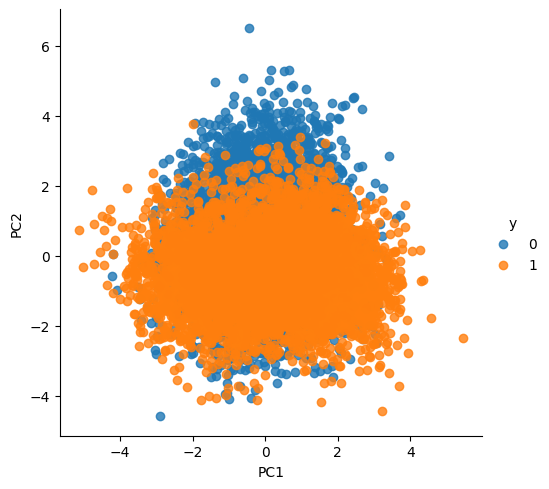

In [5]:
sns.lmplot(x="PC1", y="PC2", data=pca_df, hue="y", fit_reg=False, legend=True)

In [6]:
# Adding an intercept
temp_data = np.ones((data.shape[0], data.shape[1] + 1))
temp_data[:, 1:] = scaled_data
data = temp_data
data.shape

(10000, 41)

In [7]:
d = data.shape[1]
d

41

## Logistic Regression

We compute LR with scikit-learn to compare our results

In [8]:
rho = 1

In [9]:
clf = LogisticRegression(
    penalty="l2", C=rho, fit_intercept=False, solver="liblinear"
).fit(data, y)
y_pred = clf.predict(data)
y_pred_proba = clf.predict_proba(data)
clf.score(data, y)  # compute accuracy

0.7911

In [10]:
opt_theta = clf.coef_
opt_theta

array([[-0.0109321 ,  0.00146945,  0.67497892,  0.00496842, -0.58007062,
        -0.02913996, -0.46155533, -0.31853267,  0.04216946,  0.01051193,
         0.00939834,  0.0267916 ,  0.53042505, -0.00978505, -0.01669377,
        -0.00649668,  0.04412113,  0.02029537,  0.00423293,  0.03742701,
        -0.03261784,  0.02937113,  0.01691311, -0.92115248, -0.03524279,
         0.05063721, -0.00178869,  0.0372347 , -0.01563854,  0.02143344,
         0.02229454, -0.00416528,  0.49166668, -0.02668492, -0.03642686,
         0.02116626,  0.58303667, -0.82184361,  0.00441912,  0.01553641,
        -0.87573313]])

In [11]:
loss = log_loss(y, y_pred_proba, labels=[0, 1])
loss

0.4508221153758557

## ADMM not parallelized

In [12]:
K = 200  # number of iterations
M = 4  # number of workers
rho = 1

In [13]:
split_data = np.array_split(data, M)

In [14]:
split_data[0].shape

(2500, 41)

In [15]:
split_y = np.array_split(y, M)

In [16]:
f(opt_theta, data, y)

0.4508221153758557

In [17]:
# Initialisation
Theta = np.zeros((M, d))
global_theta = np.zeros(d)
Lamb = np.zeros((M, d))

df_log_admm = []

t1 = time.time()
for k in trange(K):
    # Step 1 : find argmin of objective function
    for n in range(M):
        sample_data = split_data[n]
        sample_y = split_y[n]
        lamb = Lamb[n]
        res = minimize(
            admm_objective_function,
            x0=Theta[n],
            args=(sample_data, sample_y, lamb, global_theta, rho),
        )
        assert res.success is True
        Theta[n] = res.x

    # Step 2 : update global_theta
    Sum_Theta = np.sum(Theta, axis=0)
    Sum_Lamb = np.sum(Lamb, axis=0)
    global_theta = (1 / M) * (Sum_Theta + (1 / rho) * Sum_Lamb)

    # Step 3 : update locally lambda
    for n in range(M):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - global_theta)

    for n in range(M):
        df_log_admm.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log_admm)

print(f"Temps : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t1))}")

  0%|          | 0/200 [00:00<?, ?it/s]

Temps : 00:05:20


In [18]:
Theta[0]

array([-0.01091345,  0.00145045,  0.67616925,  0.0050019 , -0.58125701,
       -0.02988262, -0.46232399, -0.31884208,  0.04247416,  0.01054398,
        0.00942942,  0.02686517,  0.5314095 , -0.0097823 , -0.01671521,
       -0.00650818,  0.04417953,  0.02033499,  0.00424374,  0.03747483,
       -0.03266559,  0.02943523,  0.01699836, -0.92308185, -0.03529916,
        0.05071957, -0.00178949,  0.037284  , -0.01563203,  0.02143964,
        0.02231907, -0.00415191,  0.49263874, -0.02672095, -0.03648026,
        0.02134884,  0.58411425, -0.82334803,  0.00440839,  0.01562552,
       -0.87737166])

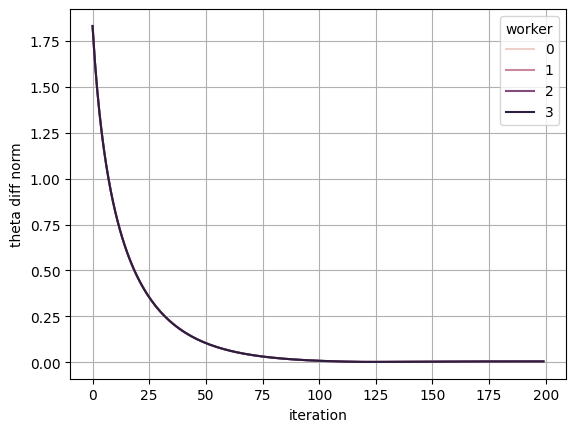

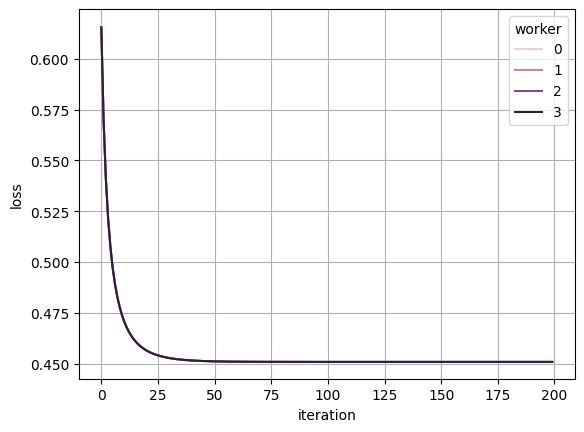

,worker,theta diff norm,loss
0,0,0.003999,0.450822
1,1,0.003990,0.450822
2,2,0.003986,0.450822
3,3,0.004000,0.450822


In [19]:
display_df_log(df_log, data, y, M, Theta, opt_theta)

In [20]:
print(
    f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}"
)

Temps d'exécution total : 00:05:24
